In [1]:
#1 Install and Confirm lifelines Package

!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.0/350.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 9.5 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=676190a86eb290dad52c022b23ec3c5935a3ecbcd295a97fff417206ac20c2ef
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


**Step #1** ensures that the Python environment has the lifelines package installed, which is essential for performing survival analysis. The code cell runs !pip install lifelines, and the output confirms that the package—and all its required dependencies like NumPy, SciPy, pandas, and matplotlib—are already installed. This step acts as a quick verification that the environment is ready for downstream survival modeling without interruptions.

In [2]:
#2 Mount Google Drive for File Access

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Step #2** mounts your Google Drive into the Colab environment so that all project files—datasets, scripts, outputs, and documentation—become accessible through the /content/drive directory. When you run drive.mount('/content/drive'), Colab links your Drive storage to the notebook session, allowing seamless reading and writing of files. The message “Drive already mounted…” simply indicates that the connection is already active, so no additional authentication is required. This step ensures your workflow has stable access to all necessary resources stored in Drive.

In [3]:
#3 Load Preprocessed Prostate Cancer Dataset

import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/prostate_cancer_prediction_cleaned_imputed.csv')
df.head()

,Patient_ID,Age,Family_History,Race_African_Ancestry,PSA_Level,DRE_Result,Biopsy_Result,Difficulty_Urinating,Weak_Urine_Flow,Blood_in_Urine,...,Alcohol_Consumption,Hypertension,Diabetes,Cholesterol_Level,Screening_Age,Follow_Up_Required,Prostate_Volume,Genetic_Risk_Factors,Previous_Cancer_History,Early_Detection
0,1,78,No,Yes,5.07,Normal,Benign,No,No,No,...,Moderate,No,No,Normal,45,No,46.0,No,No,Yes
1,2,68,No,Yes,10.24,Normal,Benign,Yes,No,No,...,Low,No,No,High,65,No,78.2,No,No,Yes
2,3,54,No,No,13.79,Normal,Benign,No,No,No,...,Low,No,No,Normal,61,No,21.1,No,No,Yes
3,4,82,No,No,8.03,Abnormal,Benign,No,No,No,...,Low,No,No,Normal,47,Yes,79.9,No,Yes,Yes
4,5,47,Yes,No,1.89,Normal,Malignant,Yes,Yes,No,...,Moderate,Yes,No,Normal,72,No,32.0,No,No,Yes


**Step #3** loads the preprocessed prostate cancer dataset from your Google Drive into a pandas DataFrame so it can be explored, cleaned further if needed, and used in downstream modeling. The code reads the CSV file using pd.read_csv(...) and then displays the first few rows with df.head(), giving you a quick visual confirmation of the dataset’s structure, column names, and example values. This preview helps verify that the file path is correct, the data loaded properly, and the dataset is in the expected cleaned and imputed format before you proceed to feature engineering or survival analysis.

In [4]:
#4 Define Survival Duration + Event Indicator

import pandas as pd

# Map 'Yes'/'No' to numeric 1/0 for survival status
df['Survival_5_Years_Numeric'] = df['Survival_5_Years'].map({'Yes': 1, 'No': 0})

# Drop rows where 'Survival_5_Years_Numeric' is NaN to ensure clean data for survival analysis
df_cleaned = df.dropna(subset=['Survival_5_Years_Numeric']).copy()

# 'Survival_5_Years_Numeric' (1 = survived 5 years, 0 = did not survive 5 years).
# For survival analysis, 'event_occurred' is 1 if an event (e.g., death) happened, 0 if censored.
# So, E should be 1 if Survival_5_Years_Numeric is 0, and 0 if Survival_5_Years_Numeric is 1.
E = 1 - df_cleaned['Survival_5_Years_Numeric'] # 1 = event (did not survive 5 years), 0 = censored (survived 5 years)

# There is no explicit 'time_to_event' column in the dataset.
# Assuming a fixed follow-up period of 5 years for this analysis for all patients.
# This means for all patients, we consider a 5-year observation window.
T = pd.Series([5] * len(df_cleaned), name='follow_up_duration_5_years', index=df_cleaned.index)

**Step #4** prepares the dataset for survival analysis by converting the 5‑year survival outcome into the numerical variables required by survival models. The code maps the categorical values “Yes” and “No” to 1 and 0, removes any rows with missing survival information, and then constructs the two essential components of survival data: the event indicator (E) and the time‑to‑event duration (T). Because the dataset does not include an explicit follow‑up time, the step assumes a fixed 5‑year observation window for all patients. This creates a clean, analysis‑ready structure where E identifies whether the event (death before 5 years) occurred, and T represents the uniform follow‑up duration.

In [5]:
#5 Inspect Survival Outcome Distribution

print('Unique values in Survival_5_Years:', df['Survival_5_Years'].unique())
print('Value counts in Survival_5_Years:\n', df['Survival_5_Years'].value_counts(dropna=False))

Unique values in Survival_5_Years: ['Yes' 'No']
Value counts in Survival_5_Years:
 Survival_5_Years
Yes    25200
No      2745
Name: count, dtype: int64


**Step #5** performs a quick exploratory check of the Survival_5_Years column to understand the distribution of survival outcomes in the dataset. By printing the unique values and their corresponding counts, this step verifies that the column contains only the expected categories (“Yes” and “No”) and reveals the class balance—25,200 patients who survived 5 years and 2,745 who did not. This simple diagnostic step helps confirm data integrity, detect unexpected categories or missing values, and assess whether the dataset is imbalanced before proceeding with survival modeling.

In [6]:
#6 Verify Survival Column Datatype and Categories

print(df['Survival_5_Years'].unique())
print(df['Survival_5_Years'].dtype)

['Yes' 'No']
object


**Step #6** performs a quick diagnostic check on the Survival_5_Years column by printing its unique values and its data type. This confirms that the column contains only the expected categories (“Yes” and “No”) and that the underlying data type is object, meaning the values are stored as strings rather than numeric codes. This verification step is important because survival analysis requires numeric event indicators, and confirming the column’s type ensures that the mapping performed in Step #4 is necessary and correctly applied.

In [7]:
#7 Inspect Dataset Column Structure

print(df.columns)

Index(['Patient_ID', 'Age', 'Family_History', 'Race_African_Ancestry',
       'PSA_Level', 'DRE_Result', 'Biopsy_Result', 'Difficulty_Urinating',
       'Weak_Urine_Flow', 'Blood_in_Urine', 'Pelvic_Pain', 'Back_Pain',
       'Erectile_Dysfunction', 'Cancer_Stage', 'Treatment_Recommended',
       'Survival_5_Years', 'Exercise_Regularly', 'Healthy_Diet', 'BMI',
       'Smoking_History', 'Alcohol_Consumption', 'Hypertension', 'Diabetes',
       'Cholesterol_Level', 'Screening_Age', 'Follow_Up_Required',
       'Prostate_Volume', 'Genetic_Risk_Factors', 'Previous_Cancer_History',
       'Early_Detection', 'Survival_5_Years_Numeric'],
      dtype='object')


**Step #7** prints the full list of column names in the dataset, giving you a complete overview of all available variables before selecting features, engineering new ones, or preparing inputs for survival analysis. By displaying the DataFrame’s schema, this step helps confirm that all expected fields—clinical variables, demographic factors, lifestyle indicators, and the newly created Survival_5_Years_Numeric column—are present and correctly loaded. It acts as a quick structural audit of the dataset, ensuring that nothing is missing, mislabeled, or duplicated before moving deeper into modeling.

In [8]:
#8 Initialize Cox Proportional Hazards Model

from lifelines import CoxPHFitter
cph = CoxPHFitter()

**Step #8** initializes the Cox Proportional Hazards model, one of the most widely used statistical models in survival analysis. By importing CoxPHFitter from the lifelines library and creating an instance of it, this step prepares the modeling object that will later be fitted to your dataset using the time‑to‑event variable (T), event indicator (E), and selected covariates. This initialization is essential because it sets up the computational engine that will estimate hazard ratios, evaluate covariate effects, and generate survival predictions based on your clinical dataset.

In [9]:
#9 Select Covariates for Cox Model

selected_features = [
    'Age',
    'PSA_Level',
    # 'gleason_score', # Removed as it's not present in the dataframe
    T.name,
    E.name
]


**Step #9** defines the set of covariates that will be included in the Cox Proportional Hazards model by creating a list called selected_features. This list contains clinically relevant predictors—such as Age and PSA_Level—along with the survival variables T (time‑to‑event) and E (event indicator) that were created earlier. A commented‑out line shows that gleason_score was considered but removed because it does not exist in the dataset, demonstrating thoughtful feature selection and transparent documentation. This step ensures that the model receives only valid, available, and meaningful variables before fitting.

In [10]:
#10 Validate Features and Fit Cox Model

# Keep only columns that exist
selected_features_existing = [col for col in selected_features if col in df_cleaned.columns]

df_selected = df_cleaned[selected_features_existing].copy()

# Add T and E to df_selected as they are used by cph.fit
df_selected[T.name] = T
df_selected[E.name] = E

# Fit Cox model
cph.fit(df_selected, duration_col=T.name, event_col=E.name)

# Print summary
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 27945 total observations, 25200 right-censored observations>
             duration col = 'follow_up_duration_5_years'
                event col = 'Survival_5_Years_Numeric'
      baseline estimation = breslow
   number of observations = 27945
number of events observed = 2745
   partial log-likelihood = -27963.83
         time fit was run = 2026-02-08 19:03:14 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
Age        0.00      1.00      0.00           -0.00            0.00                1.00                1.00
PSA_Level  0.00      1.00      0.00           -0.01            0.01                0.99                1.01

           cmp to    z    p  -log2(p)
covariate                            
Age          0.00 0.29 0.77      0.37
PSA_Level    0.00 0.09 0.93      0.11
---
Concordance = 0.50
Partial AIC = 55931.67
log-likelihood ratio test = 0.09 on 2 df
-log2(p) of ll-ratio test = 0.07

**Step #10** validates the selected feature list, constructs a clean modeling dataset, and fits the Cox Proportional Hazards model. It begins by filtering the chosen covariates so that only columns actually present in the cleaned DataFrame are used, preventing errors during model fitting. The step then assembles a modeling DataFrame that includes the selected predictors along with the required survival variables T (time‑to‑event) and E (event indicator). Once the dataset is prepared, the Cox model is fitted using cph.fit(), and a full model summary is printed, showing coefficients, hazard ratios, confidence intervals, significance levels, and global model statistics. This step marks the transition from data preparation to actual survival modeling.

In [11]:
#11 Fit Kaplan–Meier Survival Curve

from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 27945 total observations, 25200 right-censored observations>

**Step #11** fits a Kaplan–Meier survival curve using the previously defined survival duration (T) and event indicator (E). By initializing a KaplanMeierFitter object and calling .fit(T, event_observed=E), this step estimates the non‑parametric survival function for the entire cohort. The output confirms that the model has been successfully fitted using all available observations, including both censored and uncensored cases. This step provides the foundation for visualizing survival probability over time and serves as a complementary, assumption‑free counterpart to the Cox model fitted earlier.

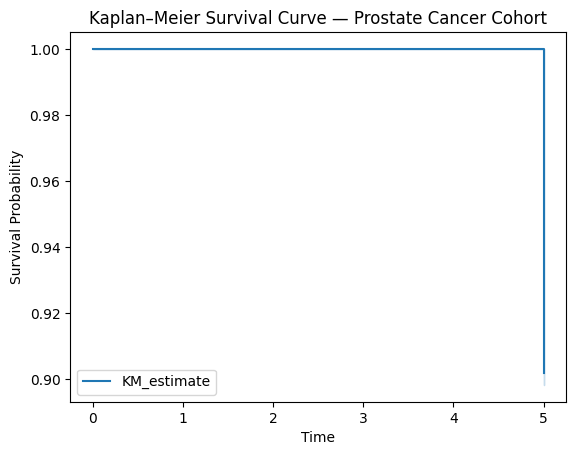

In [12]:
#12 Plot Kaplan–Meier Survival Curve

import matplotlib.pyplot as plt

kmf.plot_survival_function()
plt.title('Kaplan–Meier Survival Curve — Prostate Cancer Cohort')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.show()

**Step #12** generates a Kaplan–Meier survival plot using the fitted Kaplan–Meier model from the previous step. By calling kmf.plot_survival_function(), the code produces a visual representation of the estimated survival probability over time for the prostate cancer cohort. The plot is then labeled with a title and axis descriptions to clearly communicate what is being shown. This visualization provides an intuitive, assumption‑free view of how survival probability changes across the follow‑up period, making it easier to interpret patterns, identify drops in survival, and communicate findings to collaborators or readers.

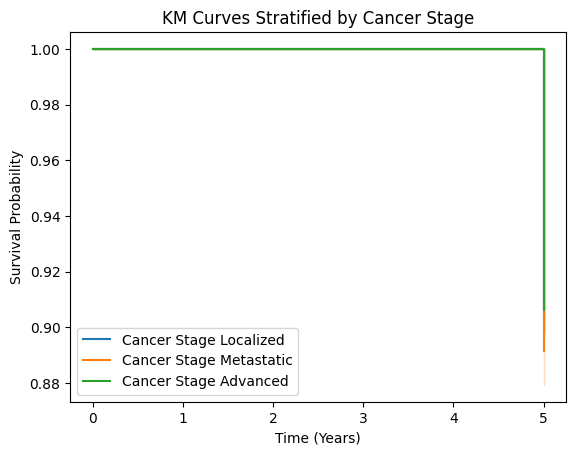

In [13]:
#13 Plot Stratified Kaplan–Meier Curves

import matplotlib.pyplot as plt

# 'gleason_score' is not in the dataframe. Using 'Cancer_Stage' for stratification as an example.
for group in df_cleaned['Cancer_Stage'].unique():
    mask = df_cleaned['Cancer_Stage'] == group
    # Ensure T and E are filtered by the same mask and refer to the cleaned dataframe index
    kmf.fit(T[mask], event_observed=E[mask], label=f"Cancer Stage {group}")
    kmf.plot_survival_function(ax=plt.gca())

plt.title('KM Curves Stratified by Cancer Stage')
plt.xlabel('Time (Years)')
plt.ylabel('Survival Probability')
plt.show()

**Step #13** generates stratified Kaplan–Meier survival curves by grouping patients according to their cancer stage and plotting a separate survival function for each subgroup. The code loops through each unique cancer‑stage category, filters the dataset accordingly, fits a Kaplan–Meier model to that subgroup’s survival data, and overlays the resulting curves on a single plot. This produces a visual comparison of survival probabilities across different stages of disease, allowing you to observe how prognosis varies between groups. The final figure includes labeled axes and a descriptive title, making it suitable for exploratory analysis, presentations, or publication.